# A Mixed Integer Programming for Risk-Aware Portfolio Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from docplex.mp.model import Model

## 1. Tiền xử lí dữ liệu

In [2]:
# Đọc dữ liệu giá đóng cửa
df_prices = pd.read_csv("2012–2014_ Recovery - Trang tính1.csv", index_col=0, parse_dates=True)

# Kiểm tra số lượng giá trị NaN theo cột
print("Số lượng NaN mỗi cổ phiếu cho giai đoạn Recovery:")
print(df_prices.isnull().sum())

# Đọc dữ liệu giá đóng cửa
df_prices = pd.read_csv("2015–2017_ Expansion - Trang tính1.csv", index_col=0, parse_dates=True)

# Kiểm tra số lượng giá trị NaN theo cột
print("Số lượng NaN mỗi cổ phiếu cho giai đoạn Expansion:")
print(df_prices.isnull().sum())

# Đọc dữ liệu giá đóng cửa
df_prices = pd.read_csv("2018–2020_ Contraction - Trang tính1.csv", index_col=0, parse_dates=True)

# Kiểm tra số lượng giá trị NaN theo cột
print("Số lượng NaN mỗi cổ phiếu cho giai đoạn Contraction:")
print(df_prices.isnull().sum())

# Đọc dữ liệu giá đóng cửa
df_prices = pd.read_csv("2021–2023_ Expansion → Recession → Recovery - Trang tính1.csv", index_col=0, parse_dates=True)

# Kiểm tra số lượng giá trị NaN theo cột
print("Số lượng NaN mỗi cổ phiếu cho giai đoạn Expansion → Recession → Recovery:")
print(df_prices.isnull().sum())


Số lượng NaN mỗi cổ phiếu cho giai đoạn Recovery:
ACB     0
AGR     0
CTC    17
CTG     0
EIB     0
HOM     1
MAS    68
MBB     0
SHB     0
STB     0
dtype: int64
Số lượng NaN mỗi cổ phiếu cho giai đoạn Expansion:
ACB    0
AGR    0
CTC    0
CTG    0
EIB    0
HOM    0
MAS    0
MBB    0
SHB    0
STB    0
dtype: int64
Số lượng NaN mỗi cổ phiếu cho giai đoạn Contraction:
ACB    0
AGR    0
CTC    0
CTG    0
EIB    0
HOM    0
MAS    0
MBB    0
SHB    0
STB    0
dtype: int64
Số lượng NaN mỗi cổ phiếu cho giai đoạn Expansion → Recession → Recovery:
ACB    0
AGR    0
CTC    3
CTG    0
EIB    0
HOM    4
MAS    3
MBB    0
SHB    3
STB    0
dtype: int64


In [3]:
def interpolate_and_save(file_path, stage_name, output_name):
    print(f"\n➡️ Xử lý giai đoạn: {stage_name}")
    
    # Đọc dữ liệu
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    
    # Trước nội suy
    print("🔍 Số lượng NaN trước xử lý:")
    print(df.isnull().sum())
    
    # Nội suy theo phương pháp tuyến tính (linear interpolation)
    df_interpolated = df.interpolate(method='linear', limit_direction='both')
    
    # Sau nội suy
    print("✅ Số lượng NaN sau xử lý:")
    print(df_interpolated.isnull().sum())
    
    # Lưu lại file đã xử lý
    df_interpolated.to_csv(output_name)
    print(f"💾 Đã lưu: {output_name}")

# Xử lý 4 giai đoạn
interpolate_and_save("2012–2014_ Recovery - Trang tính1.csv", "Recovery", "cleaned_Recovery.csv")
interpolate_and_save("2015–2017_ Expansion - Trang tính1.csv", "Expansion", "cleaned_Expansion.csv")
interpolate_and_save("2018–2020_ Contraction - Trang tính1.csv", "Contraction", "cleaned_Contraction.csv")
interpolate_and_save("2021–2023_ Expansion → Recession → Recovery - Trang tính1.csv", "Expansion→Recession→Recovery", "cleaned_Exp_Rec_Rec.csv")



➡️ Xử lý giai đoạn: Recovery
🔍 Số lượng NaN trước xử lý:
ACB     0
AGR     0
CTC    17
CTG     0
EIB     0
HOM     1
MAS    68
MBB     0
SHB     0
STB     0
dtype: int64
✅ Số lượng NaN sau xử lý:
ACB    0
AGR    0
CTC    0
CTG    0
EIB    0
HOM    0
MAS    0
MBB    0
SHB    0
STB    0
dtype: int64
💾 Đã lưu: cleaned_Recovery.csv

➡️ Xử lý giai đoạn: Expansion
🔍 Số lượng NaN trước xử lý:
ACB    0
AGR    0
CTC    0
CTG    0
EIB    0
HOM    0
MAS    0
MBB    0
SHB    0
STB    0
dtype: int64
✅ Số lượng NaN sau xử lý:
ACB    0
AGR    0
CTC    0
CTG    0
EIB    0
HOM    0
MAS    0
MBB    0
SHB    0
STB    0
dtype: int64
💾 Đã lưu: cleaned_Expansion.csv

➡️ Xử lý giai đoạn: Contraction
🔍 Số lượng NaN trước xử lý:
ACB    0
AGR    0
CTC    0
CTG    0
EIB    0
HOM    0
MAS    0
MBB    0
SHB    0
STB    0
dtype: int64
✅ Số lượng NaN sau xử lý:
ACB    0
AGR    0
CTC    0
CTG    0
EIB    0
HOM    0
MAS    0
MBB    0
SHB    0
STB    0
dtype: int64
💾 Đã lưu: cleaned_Contraction.csv

➡️ Xử lý giai đoạn

## 2. Mô phỏng lợi suất bằng Monte Carlo

In [62]:
# !pip install matplotlib

In [63]:
# !pip install seaborn

Kỳ vọng lợi suất ước tính từ mô phỏng (μ_i):
[-4.24643409e-05  5.63999505e-03  9.47141476e-04 -4.71733247e-03
 -1.79160583e-04 -1.95503211e-04 -1.27560987e-02  1.63823764e-04
  1.21254389e-02  1.07490149e-02]


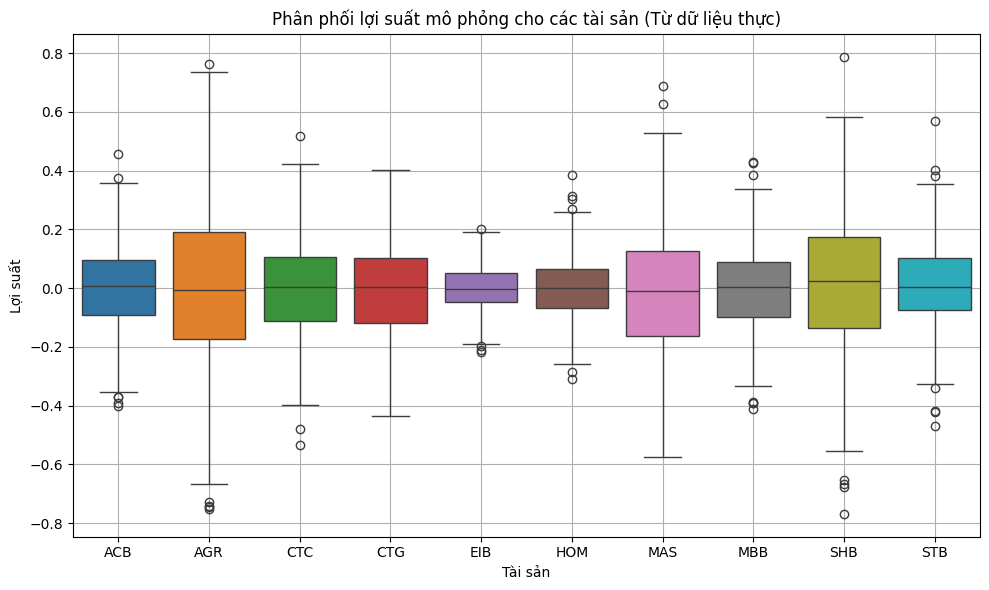

In [64]:
# Thiết lập tham số mô phỏng
np.random.seed(42)
n_scenarios = 500  # Số kịch bản Monte Carlo

# === 1. Đọc dữ liệu giá đóng cửa từ file CSV ===
file_path = "cleaned_Contraction.csv"  # có thể thay bằng các giai đoạn khác
df_prices = pd.read_csv(file_path, index_col=0, parse_dates=True)

# === 2. Tính lợi suất log từ giá đóng cửa ===
log_returns = np.log(df_prices / df_prices.shift(1)).dropna()

# === 3. Lấy kỳ vọng và độ lệch chuẩn thực tế ===
expected_returns = log_returns.mean().values
volatility = log_returns.std().values
n_assets = len(expected_returns)

# === 4. Mô phỏng lợi suất từ phân phối chuẩn ===
simulated_returns = np.random.normal(
    loc=expected_returns,
    scale=volatility,
    size=(n_scenarios, n_assets)
)

# === 5. Chuyển thành DataFrame để trực quan ===
df_returns = pd.DataFrame(simulated_returns, columns=log_returns.columns)

# === 6. Tính toán lại kỳ vọng lợi suất từ mô phỏng ===
mu_estimated = df_returns.mean().values
print("Kỳ vọng lợi suất ước tính từ mô phỏng (μ_i):")
print(mu_estimated)

# === 7. Xác suất kịch bản (đều nhau) ===
p_s = np.ones(n_scenarios) / n_scenarios

# === 8. Lưu kết quả ra file ===
df_returns.to_csv("simulated_returns_from_real_data.csv", index=False)
np.savetxt("scenario_probabilities.csv", p_s, delimiter=",")

# === 9. Trực quan hóa kết quả mô phỏng ===
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_returns)
plt.title("Phân phối lợi suất mô phỏng cho các tài sản (Từ dữ liệu thực)")
plt.ylabel("Lợi suất")
plt.xlabel("Tài sản")
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. Winsorization cho lợi suất mô phỏng


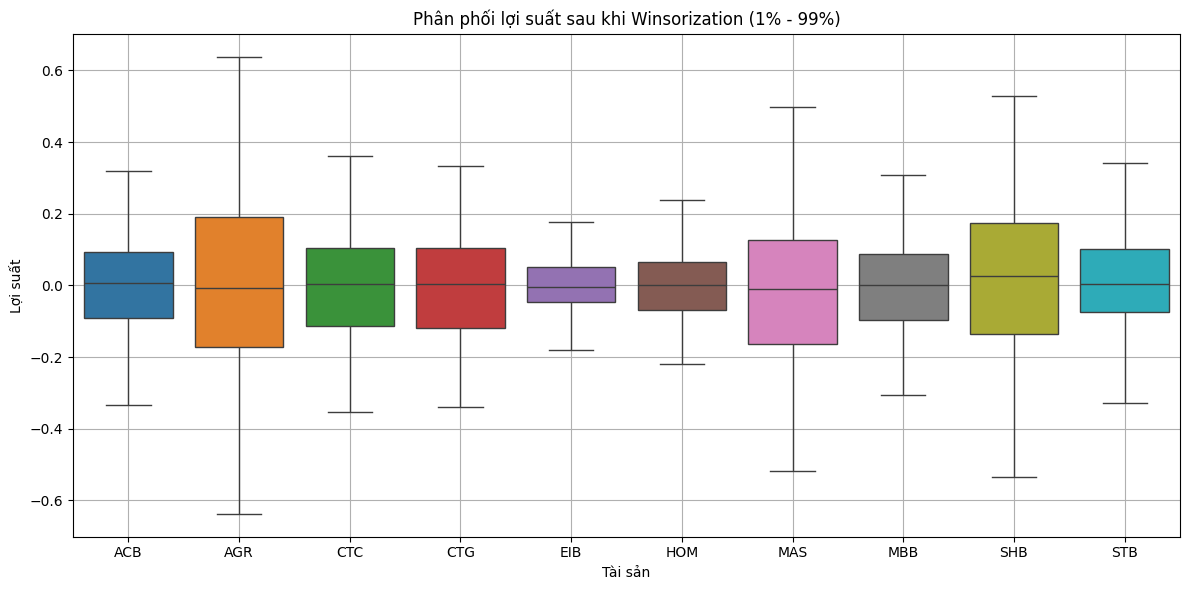

In [65]:
# === 1. Đọc dữ liệu mô phỏng đã tạo ===
df_returns = pd.read_csv("simulated_returns_from_real_data.csv")

# === 2. Áp dụng Winsorization cho từng cột (tài sản) ===
winsorized_df = df_returns.copy()
for col in winsorized_df.columns:
    # Áp dụng Winsorization: cắt 1% trên và dưới
    winsorized_df[col] = winsorize(winsorized_df[col], limits=[0.01, 0.01])

# === 3. Trực quan hóa kết quả sau khi Winsorization ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=winsorized_df)
plt.title("Phân phối lợi suất sau khi Winsorization (1% - 99%)")
plt.xlabel("Tài sản")
plt.ylabel("Lợi suất")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 4. Ghi lại dữ liệu đã xử lý nếu cần dùng tiếp ===
winsorized_df.to_csv("simulated_returns_winsorized.csv", index=False)


## 4. Tính kỳ vọng 𝜇𝑖 từ dữ liệu mô phỏng

In [66]:
# Đọc dữ liệu mô phỏng và xác suất kịch bản
df_returns = pd.read_csv("simulated_returns_winsorized.csv")  # r_{is}
p_s = np.loadtxt("scenario_probabilities.csv", delimiter=",")

# Chuyển về numpy array
r = df_returns.values  # shape (S, I)

# Tính kỳ vọng: mu_i = ∑ p_s * r_{is}
mu = np.dot(p_s, r)  # shape (I, )

# In kết quả
for i, mu_i in enumerate(mu):
    print(f"Kỳ vọng lợi suất μ_{i+1} = {mu_i:.5f}")

# Lưu ra file
np.savetxt("expected_returns_mu.csv", mu, delimiter=",")


Kỳ vọng lợi suất μ_1 = -0.00009
Kỳ vọng lợi suất μ_2 = 0.00592
Kỳ vọng lợi suất μ_3 = 0.00111
Kỳ vọng lợi suất μ_4 = -0.00476
Kỳ vọng lợi suất μ_5 = -0.00009
Kỳ vọng lợi suất μ_6 = -0.00036
Kỳ vọng lợi suất μ_7 = -0.01309
Kỳ vọng lợi suất μ_8 = 0.00024
Kỳ vọng lợi suất μ_9 = 0.01264
Kỳ vọng lợi suất μ_10 = 0.01074


## 5. Xây dựng mô hình tối ưu hóa danh mục + giải bằng Cplex

In [67]:
# !pip install docplex

In [68]:
# !pip install cplex


In [69]:
# Đọc dữ liệu
r = pd.read_csv("simulated_returns_winsorized.csv").values
p = np.loadtxt("scenario_probabilities.csv", delimiter=",")
mu = np.loadtxt("expected_returns_mu.csv", delimiter=",")

n_scenarios, n_assets = r.shape
alpha = 0.05
C = 0.001
M = 50  # nhỏ lại

# Khởi tạo mô hình
mdl = Model("VaR_Portfolio")
mdl.context.cplex_parameters.timelimit = 60  # giới hạn thời gian giải 60 giây

x = mdl.continuous_var_list(n_assets, lb=0, ub=1, name="x")
z = mdl.binary_var_list(n_scenarios, name="z")
f = mdl.continuous_var(name="f")

mdl.minimize(f)

# Ràng buộc chính
for s in range(n_scenarios):
    mdl.add_constraint(f >= mdl.sum(r[s, i] * x[i] for i in range(n_assets)) - M * z[s])

mdl.add_constraint(mdl.sum(p[s] * z[s] for s in range(n_scenarios)) <= alpha)
mdl.add_constraint(mdl.sum(x[i] for i in range(n_assets)) == 1)
mdl.add_constraint(mdl.sum(mu[i] * x[i] for i in range(n_assets)) >= C)

# Giải bài toán
solution = mdl.solve(log_output=True)

# In kết quả
if solution:
    print(f"f = {f.solution_value:.5f}")
    for i in range(n_assets):
        print(f"x[{i+1}] = {x[i].solution_value:.4f}")
else:
    print("Không tìm được lời giải khả thi.")


Version identifier: 22.1.2.0 | 2024-12-09 | 8bd2200c8
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               60
Tried aggregator 1 time.
MIP Presolve modified 6008 coefficients.
Reduced MIP has 503 rows, 511 columns, and 6019 nonzeros.
Reduced MIP has 500 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (24.39 ticks)
Found incumbent of value 1.725862 after 0.05 sec. (25.32 ticks)
Probing time = 0.00 sec. (0.11 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 503 rows, 511 columns, and 6019 nonzeros.
Reduced MIP has 500 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.20 sec. (2.94 ticks)
Probing time = 0.02 sec. (0.11 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.19 sec. (18.37 ticks)

        Nodes                                         Cuts/
  

## 6.Trực quan hóa kết quả

### 6.1. Trực quan hóa tỷ trọng đầu tư

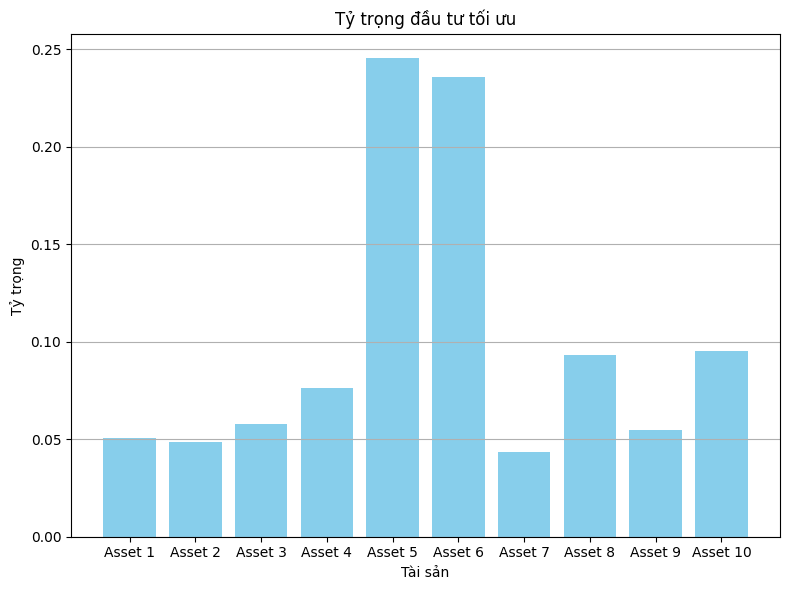

In [70]:
asset_labels = [f"Asset {i+1}" for i in range(len(x))]
weights = [x[i].solution_value for i in range(len(x))]

plt.figure(figsize=(8, 6))
plt.bar(asset_labels, weights, color='skyblue')
plt.title("Tỷ trọng đầu tư tối ưu")
plt.ylabel("Tỷ trọng")
plt.xlabel("Tài sản")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


### 6.2. Phân phối lợi suất danh mục theo các kịch bản

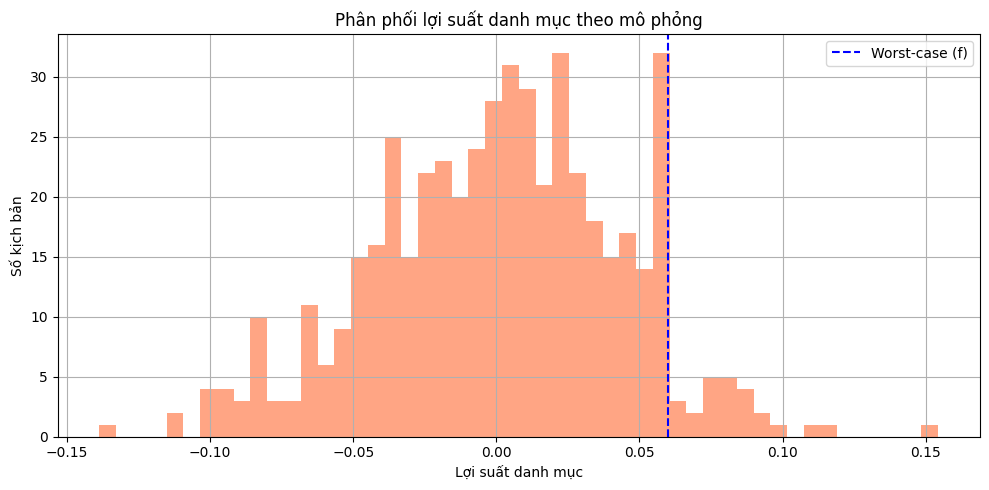

In [71]:
portfolio_returns = r @ np.array(weights)  # r_{is} * x_i
plt.figure(figsize=(10, 5))
plt.hist(portfolio_returns, bins=50, alpha=0.7, color='coral')
plt.axvline(f.solution_value, color='blue', linestyle='--', label='Worst-case (f)')
plt.title("Phân phối lợi suất danh mục theo mô phỏng")
plt.xlabel("Lợi suất danh mục")
plt.ylabel("Số kịch bản")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 6.3. Kiểm tra mức độ vi phạm rủi ro (số lượng 𝑧=1)

In [72]:
z_values = [z[s].solution_value for s in range(n_scenarios)]
violated = sum(z_values)

print(f"Số kịch bản bị loại bỏ (z_s = 1): {violated}/{n_scenarios}")
print(f"Tỷ lệ đúng bằng α? {np.isclose(violated / n_scenarios, alpha)}")


Số kịch bản bị loại bỏ (z_s = 1): 25.0/500
Tỷ lệ đúng bằng α? True
